In [10]:
from taseries import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Observation 1: CZZ stock price vs. Sugar future price
We plot those two series between 2015-07-01 and 2017-01-16:

In [11]:
# read sugar future SR701 data and extract price series
df = pd.read_csv('../data/SR701.csv',index_col='date',parse_dates=['date'])
stock_to_compare = 'CZZ'

# note that SR701 data is reverse chronically ordered
close_series = df['close'].shift(1).dropna()
close_series.name = 'close'
series_exp = SeriesExplorer(close_series)

ta = TAcalc()
ta.load_data('../data/{0}.csv'.format(stock_to_compare))
#now ta.data_dict['close'] gives the closing price of CZZ. Pair it with the timestamp index
se = pd.Series(ta.data_dict['close'],index=ta.datetime_index)
se.name = '{0}_close'.format(stock_to_compare)

series_exp.add_indep_vars([se])
series_exp.sync_index()
series_exp.fill_na()
#series_exp.data.head()

In [12]:
lineplot_data = (series_exp.data-series_exp.data.mean())/series_exp.data.std() #normalize the data
lineplot_data.head()

,close,CZZ_close
date,,
2015-07-15,-0.817720,0.046562
2015-07-16,-0.754319,-0.044068
2015-07-17,-0.748885,-0.180013
2015-07-20,-0.770622,-0.253650
2015-07-21,-0.830401,-0.185678


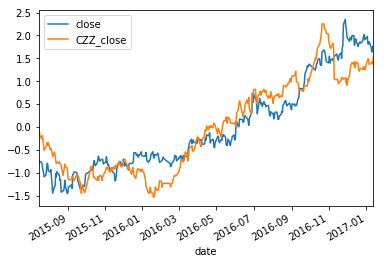

In [13]:
_ = lineplot_data.plot(y=['close',se.name],kind='line')
plt.show()

# Conclusion:
Today's price of CZZ is correlated with tomorrow's price of SR701. So it has some predict power in estimation of the price of sugar in the future.
We can also shift the series of CZZ closing price forward. We will check and see how the correlation is changing when we shift the data.

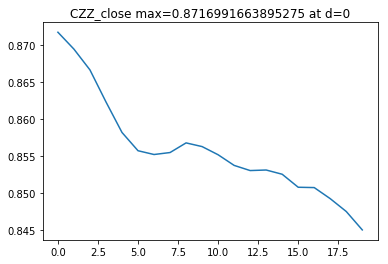

In [14]:
_ = series_exp.best_shift_test(key=se.name,method='spearman',plot=True)

We see that not shifting further gives the best correlation. However, the correlation coefficient we get keeps at a relatively high level when we shift by 0 to 20 days. So all those shifted series may be considered as potential feature variables.

# Observation 2: Return series vs Technical Indicators

In [15]:
# read sugar future SR701 data and generate return series
df = pd.read_csv('../data/SR701.csv',index_col='date',parse_dates=['date'])
hold_day = 10
# note that SR701 data is reverse chronically ordered
df['rtn'] = np.log(df['close'].shift(hold_day + 1) / df['close'].shift(1))
rtn_series = df['rtn'].dropna()
rtn_series.name = 'rtn'
#print(rtn_series)
#close_series = df['close'].shift(1).dropna()
#close_series.name = 'close'
series_exp2 = SeriesExplorer(rtn_series)

# make potential independent variable series
ta_name_list = ['BBANDS_upper','BBANDS_middle','BBANDS_lower','MA','EMA','SMA','WMA','APO','MACD','MOM','PPO','RSI','WILLR','OBV','ATR']
ta2 = TAcalc()
ta2.load_data('../data/{0}.csv'.format(stock_to_compare))

ta_se_list = []
for ta_name in ta_name_list:
    se = ta2.generate_indicator(ta_name)
    ta_se_list.append(se)
    #print(se)

series_exp2.add_indep_vars(ta_se_list)
series_exp2.sync_index()
series_exp2.fill_na()
#print(series_exp.indep[se.name])
#print(series_exp.data.head())

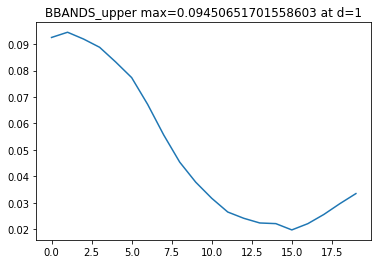

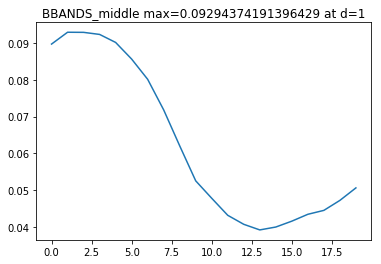

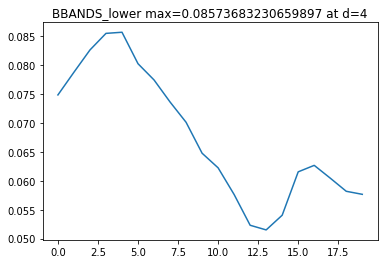

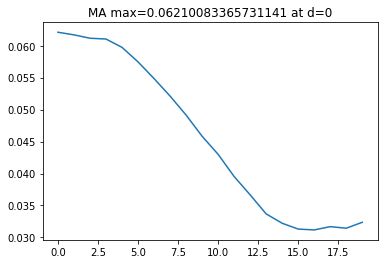

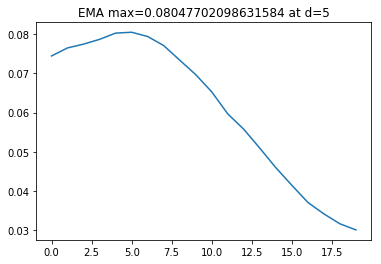

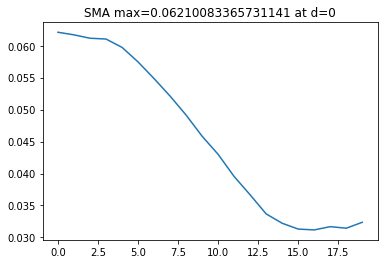

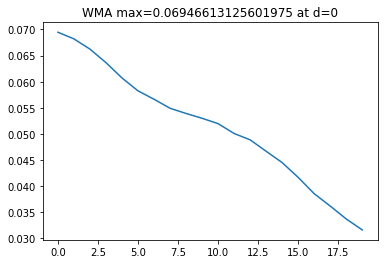

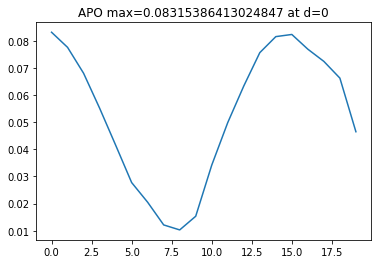

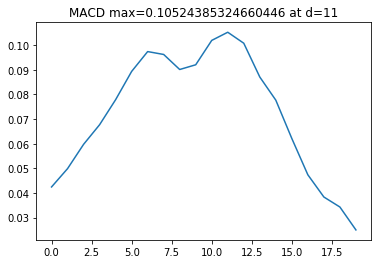

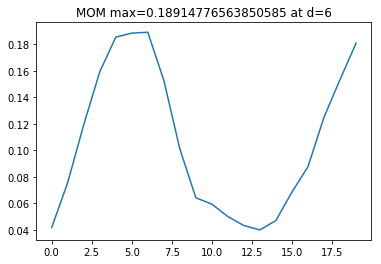

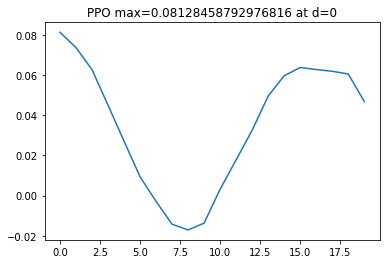

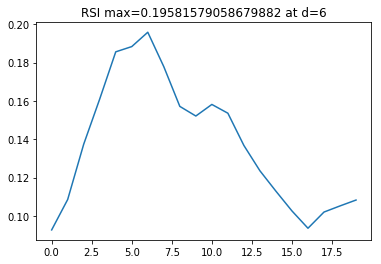

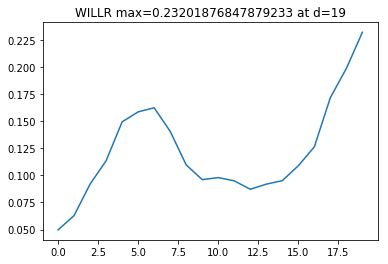

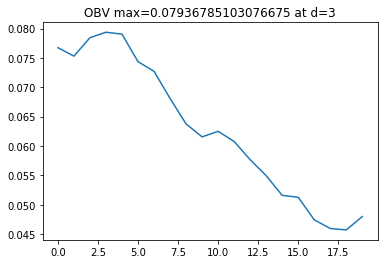

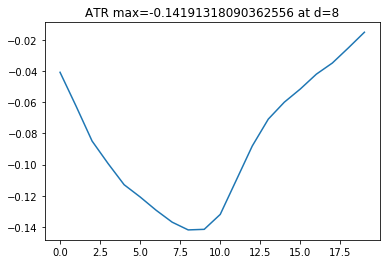

In [16]:
for ta_name in ta_name_list:
    series_exp2.best_shift_test(key=ta_name,method='spearman',plot=True)

Note that we see much weaker correlation between the technical indicators and the return series.

# Observation 3: Distribution of the return series
We take a look at the distribution of all 10-day return of SR701. It looks like the return series behaves more like a gamma distribution rather than a normal distribution.
The histogram and QQ-plots are ploted. The QQ-plots with beta distribution lies more closely to the 45-degree line.

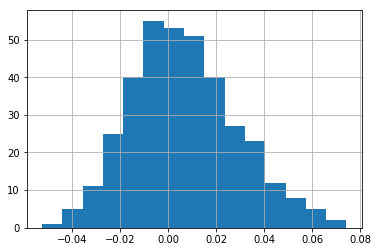

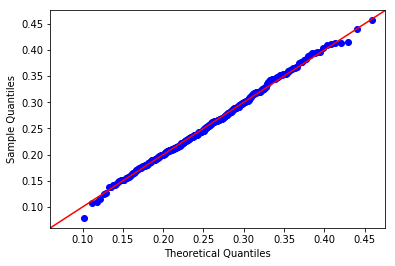

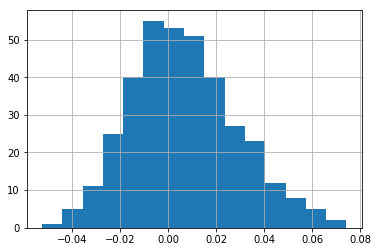

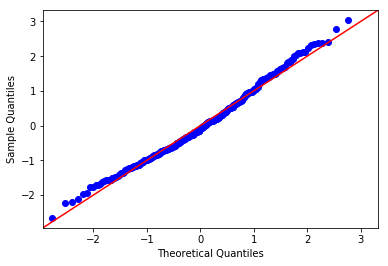

In [17]:
series_exp2.target_dist(bins=15,dist=stats.beta)
series_exp2.target_dist(bins=15)

# Observation 4: Correlations between Technical Indicators
We plot the heatmap matrix of the correlations between the technical indicators.
We can see from the picture that the "moving averages" (Bollinger bands, EMA,MA,SMA,WMA) are closely related. The indicators APO,MACD and PPO are closed because they are constructed to describe the "momentum" of the stock price time series.

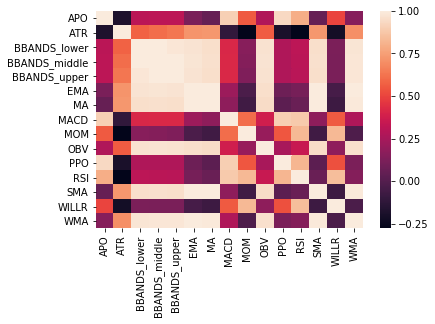

In [18]:
series_exp2.correlation_matrix()